In [47]:
################################################################################
########################          Yelp Reviews          ######################## 
########################   Classification : Catboost    ######################## 
########################  Stars on Reviews: 1 & 2 vs 5  ########################
################################################################################

In [48]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
!pip install gensim==3.8.3
!pip install catboost
!pip install optuna
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

In [50]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Fri Apr 15 12:09:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    130MiB / 15109MiB |      0%      Default |
|            

In [51]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [52]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [53]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [54]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,"[""wonderful"", ""place"", ""get"", ""lunch"", ""staff""..."
3,5.0,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel..."
5,5.0,"[""love"", ""place"", ""everything"", ""menu"", ""delic..."
7,5.0,"[""truely"", ""hidden"", ""gem"", ""place"", ""greatest..."
9,5.0,"[""seriously"", ""great"", ""fresh"", ""fantastic"", ""..."


In [55]:
# Recode to binary
df = df.copy()
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [56]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

In [11]:
# Define parameters for Word2Vec model
base_model = Word2Vec(min_count=1, window=5, size=20, workers=cores)

In [12]:
# Build vocab for model
print('Time to build vocab:', end=' ')
start = time.time()
base_model.build_vocab(features)
end = time.time()
print(round(end-start,2), 'seconds')

Time to build vocab: 74.09 seconds


In [13]:
total_examples = base_model.corpus_count

In [14]:
# Set path
%cd /content/drive/MyDrive/Yelp_Reviews/Data/preTrainedModel/

/content/drive/MyDrive/Yelp_Reviews/Data/preTrainedModel


In [15]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = ('glove.6B.50d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file) 
#After that, I could import my vectors with 
glove_vector = KeyedVectors.load_word2vec_format(tmp_file)

In [16]:
list(glove_vector.vocab.keys())

['the',
 ',',
 '.',
 'of',
 'to',
 'and',
 'in',
 'a',
 '"',
 "'s",
 'for',
 '-',
 'that',
 'on',
 'is',
 'was',
 'said',
 'with',
 'he',
 'as',
 'it',
 'by',
 'at',
 '(',
 ')',
 'from',
 'his',
 "''",
 '``',
 'an',
 'be',
 'has',
 'are',
 'have',
 'but',
 'were',
 'not',
 'this',
 'who',
 'they',
 'had',
 'i',
 'which',
 'will',
 'their',
 ':',
 'or',
 'its',
 'one',
 'after',
 'new',
 'been',
 'also',
 'we',
 'would',
 'two',
 'more',
 "'",
 'first',
 'about',
 'up',
 'when',
 'year',
 'there',
 'all',
 '--',
 'out',
 'she',
 'other',
 'people',
 "n't",
 'her',
 'percent',
 'than',
 'over',
 'into',
 'last',
 'some',
 'government',
 'time',
 '$',
 'you',
 'years',
 'if',
 'no',
 'world',
 'can',
 'three',
 'do',
 ';',
 'president',
 'only',
 'state',
 'million',
 'could',
 'us',
 'most',
 '_',
 'against',
 'u.s.',
 'so',
 'them',
 'what',
 'him',
 'united',
 'during',
 'before',
 'may',
 'since',
 'many',
 'while',
 'where',
 'states',
 'because',
 'now',
 'city',
 'made',
 'like',
 

In [17]:
base_model.build_vocab([list(glove_vector.vocab.keys())], update=True)

In [18]:
# train on your data
# Generate Word2Vec Word Embeddings
print('Time to train model:', end=' ')
start = time.time()
base_model.train(features, total_examples=total_examples, epochs=50) #base_model.epochs
end = time.time()
print(round(end-start,2), 'seconds')
base_model_wv = base_model.wv

Time to train model: 2943.23 seconds


In [19]:
glove = base_model
glove_wv = base_model.wv

In [58]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [21]:
#Saving the model
wv = glove_wv
glove.wv.save_word2vec_format('glove.6B.50dModel_review125_50epochs.bin', 
                              binary=True)

# Load model
#word2vec_path = 'glove.6B.50dModel_review125_50epochs.bin'
#model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [59]:
# Load model
word2vec_path = 'glove.6B.50dModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [60]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [61]:
print('Pipeline for Word2Vec of GloVe:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
#pl  = Pipeline([("W2vVectorizer", W2vVectorizer(glove))])
pl

Pipeline for Word2Vec of GloVe:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f8a3cbb2a10>)])

In [62]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/Model_PKL


In [63]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [64]:
################################################################################
######################    Catboost Optuna HPO    ###############################
######################  GloVe pretrained model   ###############################
######################         100 trials        ###############################
################################################################################
def cat_hpo(trial):
    """
    Objective function to tune a `CatBoostClassifier` model.
    """
    joblib.dump(study, 'Catboost_GPU_Optuna_100_glove.pkl')

    # Define parameter grid
    params_catboost_optuna = {
      #'allow_const_label': 'True',
      'iterations': trial.suggest_int('iterations', 100, 500, step=10),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',1e-8, 1e-1, log=True), 
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.000001,0.1),  
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
      'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),  
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0),
    }

    model = CatBoostClassifier(
        loss_function='Logloss',
        task_type='GPU',
        allow_const_label=True, 
        random_state=seed_value,

        **params_catboost_optuna,
    )
    
    return train_model_for_study(features, label, model)

    #        allow_const_label=True,

In [30]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('Catboost_GPU_Optuna_100_glove.pkl'):
    study = joblib.load('Catboost_GPU_Optuna_100_glove.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(cat_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
460:	learn: 0.1351336	test: 0.1589492	best: 0.1589047 (458)	total: 17.2s	remaining: 710ms
461:	learn: 0.1350874	test: 0.1589435	best: 0.1589047 (458)	total: 17.3s	remaining: 672ms
462:	learn: 0.1350178	test: 0.1589466	best: 0.1589047 (458)	total: 17.3s	remaining: 635ms
463:	learn: 0.1349522	test: 0.1589306	best: 0.1589047 (458)	total: 17.3s	remaining: 598ms
464:	learn: 0.1348888	test: 0.1589270	best: 0.1589047 (458)	total: 17.4s	remaining: 560ms
465:	learn: 0.1348340	test: 0.1589180	best: 0.1589047 (458)	total: 17.4s	remaining: 523ms
466:	learn: 0.1347568	test: 0.1589197	best: 0.1589047 (458)	total: 17.4s	remaining: 486ms
467:	learn: 0.1346873	test: 0.1589186	best: 0.1589047 (458)	total: 17.5s	remaining: 448ms
468:	learn: 0.1346417	test: 0.1589127	best: 0.1589047 (458)	total: 17.5s	remaining: 411ms
469:	learn: 0.1345737	test: 0.1589178	best: 0.1589047 (458)	total: 17.6s	remaining: 374ms
470:	learn: 0.1345321	test: 0.1589101	best: 0.158

In [31]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/trialOptions


In [32]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_depth':'depth'}, inplace=True)
trials_df.rename(columns={'params_iterations':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg':'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf':'min_data_in_leaf'}, inplace=True)
trials_df.rename(columns={'params_one_hot_max_size':'one_hot_max_size'}, inplace=True)
trials_df.rename(columns={'params_scale_pos_weight':'scale_pos_weight'}, inplace=True)

trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_GPU_100_glove.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
91         91  0.158007 2022-04-15 05:19:10.730448 2022-04-15 05:22:26.560141   
93         93  0.158046 2022-04-15 05:25:42.218826 2022-04-15 05:28:57.956652   
92         92  0.158139 2022-04-15 05:22:26.560284 2022-04-15 05:25:42.218688   
75         75  0.158219 2022-04-15 04:28:21.505707 2022-04-15 04:31:35.188013   
96         96  0.158261 2022-04-15 05:35:28.585035 2022-04-15 05:38:44.435919   
..        ...       ...                        ...                        ...   
6           6  0.689561 2022-04-15 00:53:53.095570 2022-04-15 00:56:51.595760   
39         39  0.690283 2022-04-15 02:35:35.911632 2022-04-15 02:38:37.425401   
1           1  0.690397 2022-04-15 00:38:45.849765 2022-04-15 00:41:45.541255   
13         13  0.692369 2022-04-15 01:15:15.865272 2022-04-15 01:18:25.198819   
29         29  0.692847 2022-04-15 02:04:52.956743 2022-04-15 02:07:52.243778   

                 duration  

In [33]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/Model_Explanations


In [34]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [35]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [36]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [37]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_data_in_leaf', 
                                                       'depth', 
                                                       'learning_rate', 
                                                       'one_hot_max_size'])
py.plot(fig, filename='contour_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [38]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_GPU_100_glove.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/trialOptions


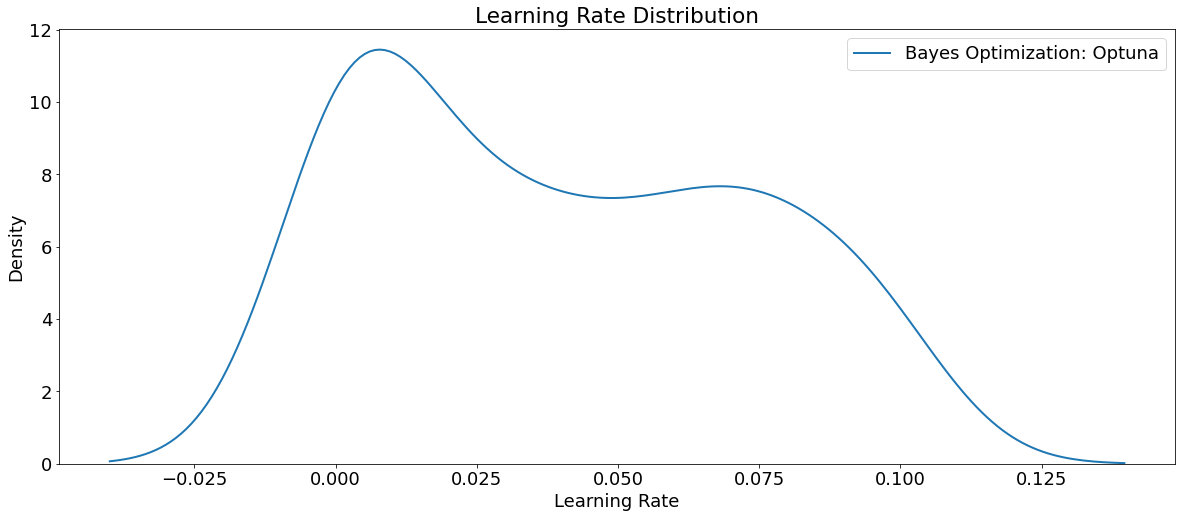

In [39]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

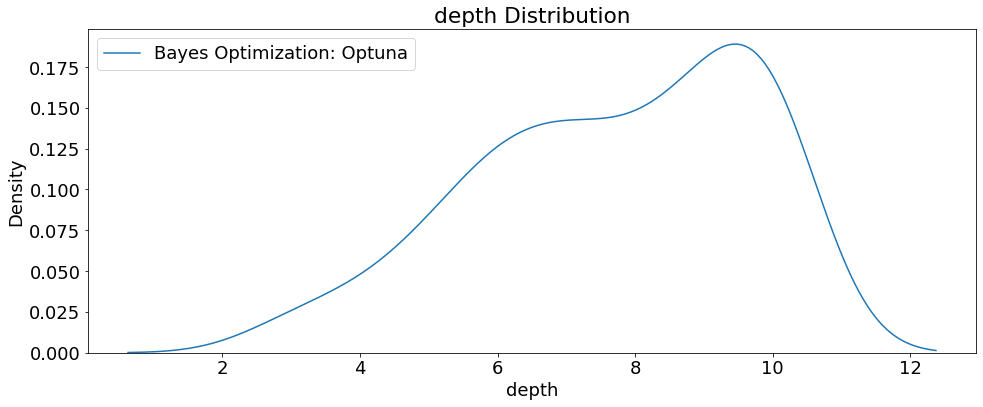

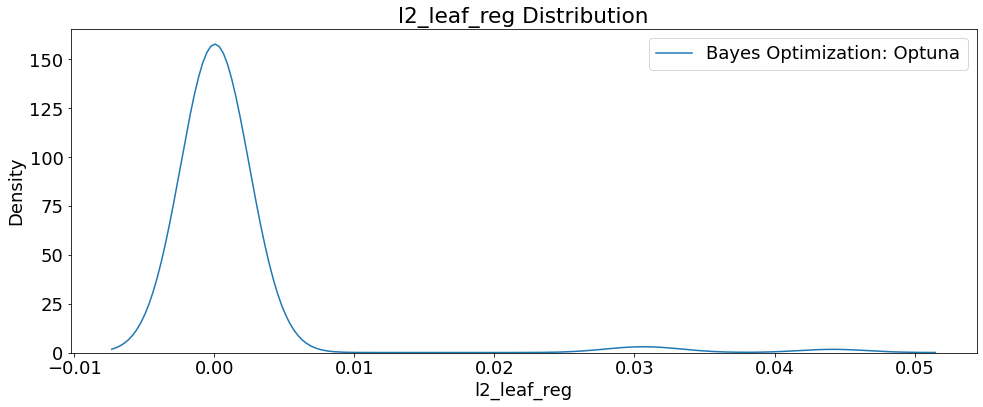

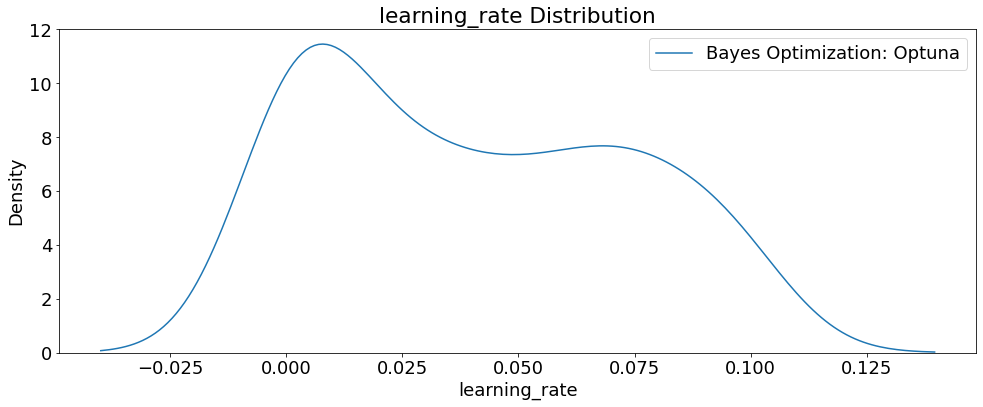

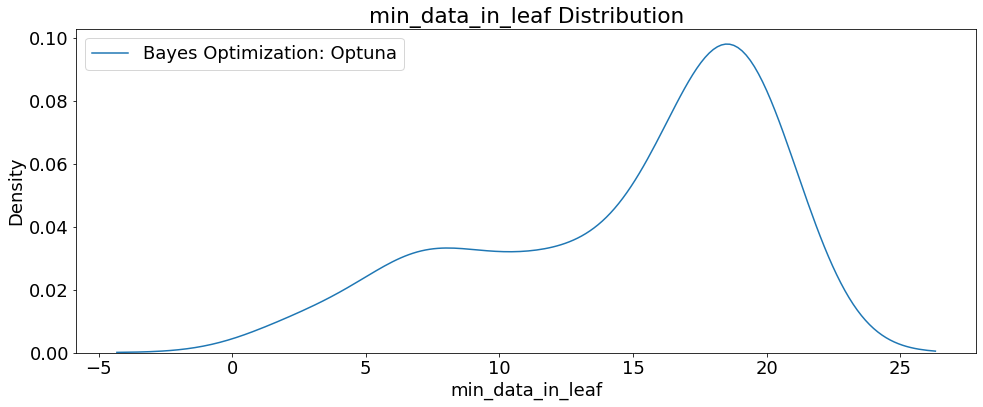

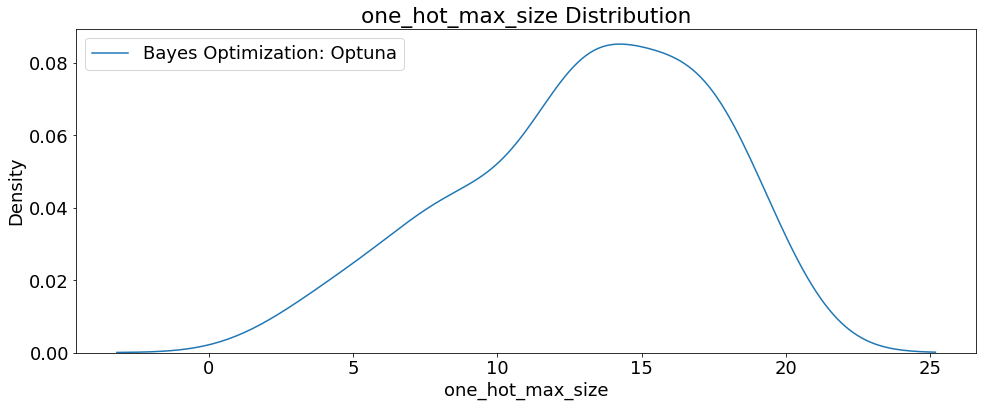

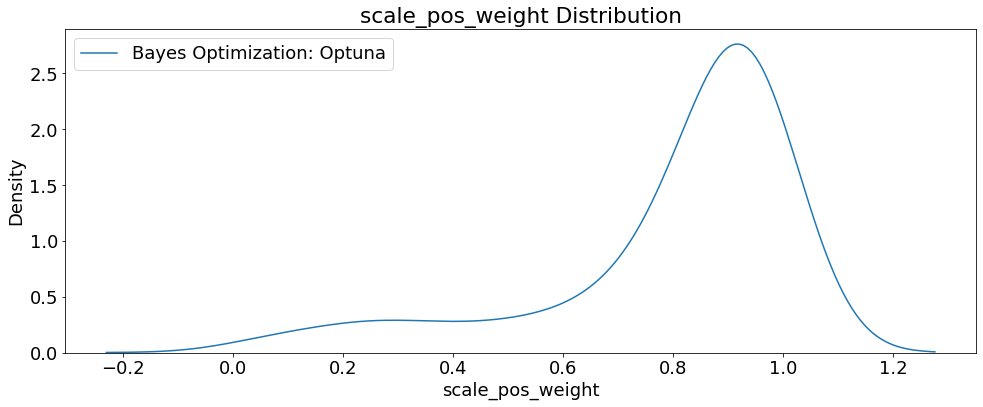

In [40]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



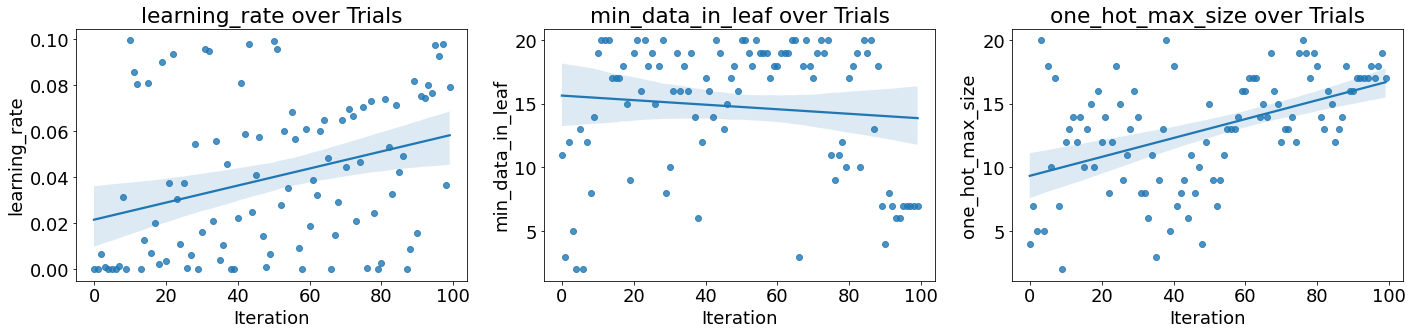

In [41]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



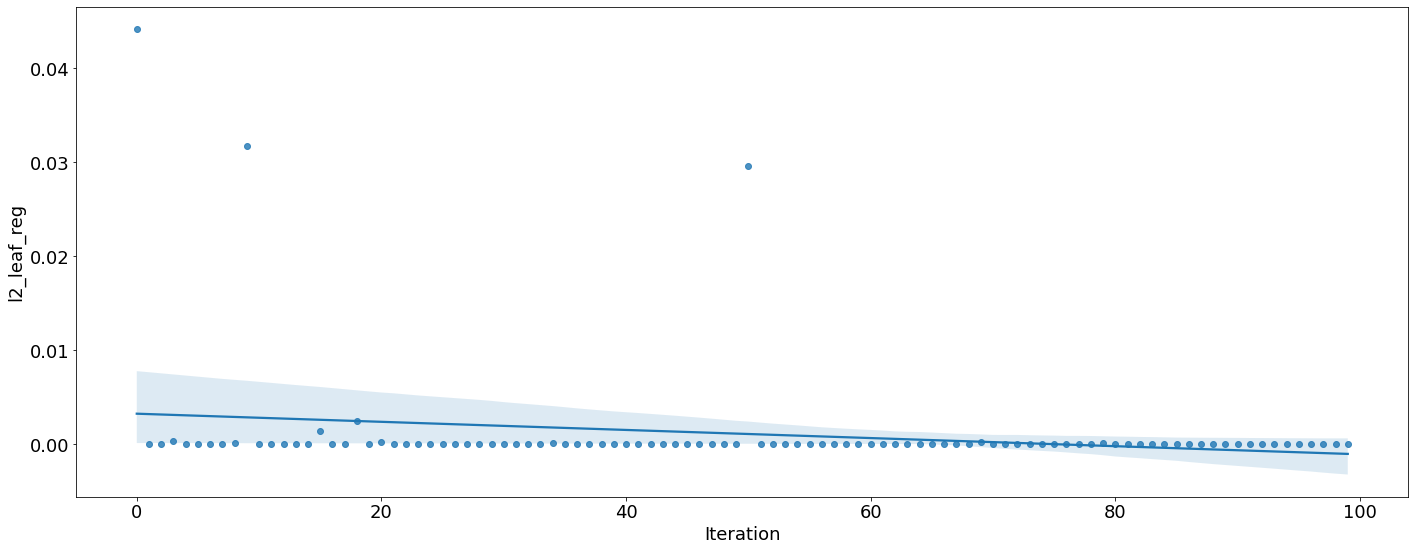

In [42]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data = trials_df, label = 'Bayes Optimization') 
ax.set(xlabel = 'Iteration', ylabel = 'l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [43]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [44]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_GPU_Optuna_100_glove.html')
fig.show()

In [66]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'depth': 10,
 'iterations': 500,
 'l2_leaf_reg': 2.4907830177372423e-06,
 'learning_rate': 0.0752229446205332,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 8,
 'one_hot_max_size': 17,
 'random_state': 42,
 'scale_pos_weight': 0.9392585971530153}

In [65]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/Model_PKL/


study = joblib.load('Catboost_GPU_Optuna_100_glove.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/Model_PKL


In [67]:
label = df[['stars_reviews']]

features = df.cleanReview

# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [68]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [69]:
# Re-create the best model and train on the training data
best_model = CatBoostClassifier(early_stopping_rounds=100,
                               rsm=1, 
                               task_type='GPU', 
                               logging_level='Silent', 
                                **params)
# Fit the model
#.ravel()
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Optuna_trials100_glove_GPU.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Optuna_trials100_glove_GPU.pkl')
# print(model)
# =============================================================================

In [70]:
print('Results from Catboost HPO Optuna 100 GloVe GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Catboost HPO Optuna 100 GloVe GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95    616594
         1.0       0.95      0.94      0.95    616594

    accuracy                           0.95   1233188
   macro avg       0.95      0.95      0.95   1233188
weighted avg       0.95      0.95      0.95   1233188



Confusion matrix: Train
[[586627  29967]
 [ 34199 582395]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    154149
         1.0       0.94      0.93      0.94    154149

    accuracy                           0.94    308298
   macro avg       0.94      0.94      0.94    308298
weighted avg       0.94      0.94      0.94    308298



Confusion matrix: Test
[[145262   8887]
 [ 10080 144069]]


Accuracy score: train: 0.948, test: 0.938
Precision score: train: 0.951, test: 0.942
Recall score: train: 0

In [71]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_GPU_100_glove.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/trialOptions


In [72]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93848 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    91
logloss                                0.158007
datetime_start       2022-04-15 05:19:10.730448
datetime_complete    2022-04-15 05:22:26.560141
duration                 0 days 00:03:15.829693
depth                                        10
n_estimators                                500
l2_leaf_reg                            0.000002
learning_rate                          0.075223
min_data_in_leaf                              8
one_hot_max_size                             17
scale_pos_weight                       0.939259
state                                  COMPLETE
Name: 0, dtype: object
